![uc3m](img/uc3m.jpg)

# Uber waiting-time: an assignment simulation 


<li> Suppose we live in a 100×100 block city where each block takes 1 minute to cross by car.


<li> Drivers can pick up
passengers only on corners, and passengers must call Uber on corners.


<li> Inferior-left corner is (1,1) and superior right
corner is (100,100)


[[ 56.  61.  96. ...  60.  63. 109.]
 [ 13.  30.  49. ...  29.  16.  62.]
 [ 41.  84.  37. ...  83.  40.  50.]
 ...
 [ 20.  63.  34. ...  62.  19.  47.]
 [ 45.  42.  67. ...  33.  46.  76.]
 [ 51.  84.  11. ...  75.  44.  14.]]


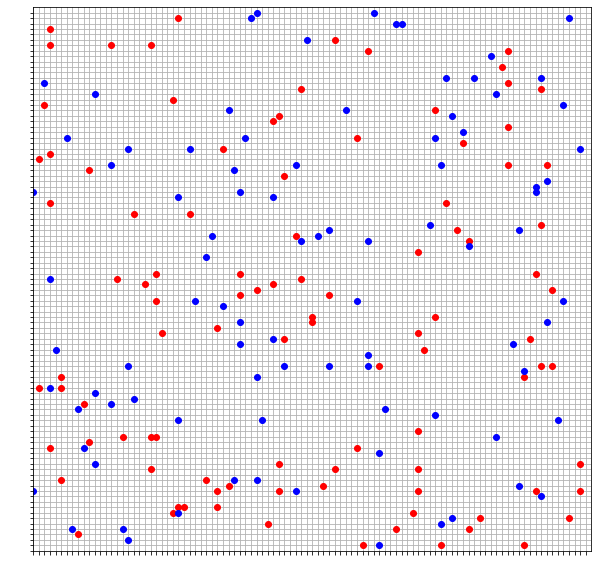

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

D=100; # number of drivers
U=90; # number of users

# Define positions in the city map: a 2×1 vector representation 

# Select D random positions for drivers
loc_d=np.random.randint(100, size=(D,2))+1

# Select U random positions for users
loc_u=np.random.randint(100, size=(U,2))+1
#print(loc_d)
#print(loc_u)

# Define Manhattan or L1 distance: sum(abs(x-y))
# the distance between a passenger and a car is simple the distance in the x-axis plus the distance in the y-axis

dist=np.zeros((U,D))
for i in range(0, U):
    for j in range(0,D):
        dist[i,j]=np.absolute(loc_d[j,0]-loc_u[i,0])+np.absolute(loc_d[j,1]-loc_u[i,1])
           
print(dist)

# Plot drivers in red, customers in blue
plt.figure(figsize=(10, 10))
plt.plot(loc_d[:,0],loc_d[:,1],'ro')
plt.plot(loc_u[:,0],loc_u[:,1],'bo')
#plt.plot(loc_d,'ro')
plt.axis([1, 101, 1, 101])
plt.xticks(np.arange(1, 101, 1),color='white')
plt.yticks(np.arange(1, 101, 1),color='white')
plt.grid() 
plt.show()

(Note we are using more cars than users)

**How can we minimize the total waiting time?**

In [2]:
### Formulation

In [3]:
from pyomo.environ import *
#opt = SolverFactory("glpk")
opt = SolverFactory("gurobi")

from pyomo.opt import SolverFactory

# Here we are going to use AbstractModel with instances

def uber_opt(U,D,dist):

    model = AbstractModel()

    model.I = RangeSet(1,U) #users
    model.J = RangeSet(1,D) #drivers

    #model.w = Param(model.I, model.J,within=NonNegativeIntegers) #compatibility score


    # variable x
    model.x = Var(model.I,model.J, domain=Binary)

    #definition of the objective function
    def obj_expression(model): 
        return sum(sum(model.x[i,j]*dist[i-1,j-1] for i in model.I) for j in model.J)## this has changed too

    model.OBJ = Objective(rule=obj_expression, sense=minimize)

    # each driver with maximum one user
    def driver_constraint_rule(model, j): 
        return sum(model.x[i,j] for i in model.I) <= 1 
    model.driver_Constraint = Constraint(model.J, rule=driver_constraint_rule)

    #each user gets one driver
    def user_constraint_rule(model, i): 
        return sum(model.x[i,j] for j in model.J) == 1
    model.user_Constraint = Constraint(model.I, rule=user_constraint_rule)
    
    instance = model.create_instance()
    #instance = model.create()
    results = opt.solve(instance)
    
    x_sol = np.zeros((U,D))
    for u in range(0, U):
        for d in range(0,D):
            x_sol[u,d]= instance.x[u+1,d+1].value
    
    return instance.OBJ(), x_sol

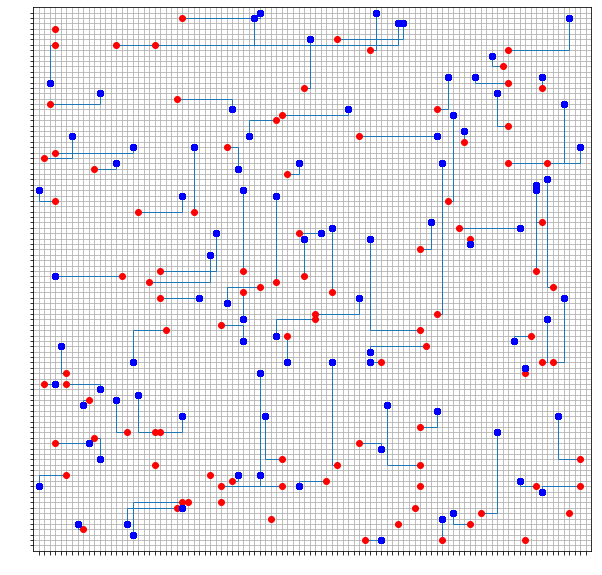

In [4]:
#solve model
[obj,x_sol]=uber_opt(U,D,dist)

#plot solution
plt.figure(figsize=(10, 10))
plt.plot(loc_d[:,0],loc_d[:,1],'ro')
plt.plot(loc_u[:,0],loc_u[:,1],'bo')
#plt.axhline(y=loc_d[5,1])
#plt.plot(loc_d,'ro')
plt.axis([0, 101, 0, 101])
plt.xticks(np.arange(1, 101, 1),color='white')
plt.yticks(np.arange(1, 101, 1),color='white')
plt.grid() 

for u in range(0, U):
    for d in range(0,D):
        if x_sol[u,d] == 1:
            plt.hlines(y=loc_d[d,1],xmin=loc_d[d,0],xmax=loc_u[u,0],linewidth=1)
            plt.vlines(x=loc_u[u,0],ymin=loc_u[u,1],ymax=loc_d[d,1],linewidth=1)
            plt.plot(loc_u[:,0],loc_u[:,1],'bo')
plt.show()

In practice, distances can be computed using Google maps, based on GPS on drivers and users, and considering also the traffic. 